### Compilation/Generation Benchmark:

#### Requirements for running:
- ZoKrates installed (via install script)


#### Select files:
- Drop all files that are supposed to be benchmarked in the files/ directory in this project

#### Python Imports:

In [1]:
%%capture
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install csv2md
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statistics
import time



#### Iterate Files:

##### Benchmark Settings:
- Each programm will be run N * R times
    - N: Number of loop iterations. The minimum value of all loop execution times is returned to eliminate side-effects from parallel processes on the benchmarking machine.
    - R: Number of repetitions in one loop. Values are averaged, stddev is calculated.

In [ ]:
compile_opt = []
compile_opt_stdev = []
setup_opt = []
setup_opt_stdev = []
witness_opt = []
witness_opt_stdev = []
proof_opt = []
proof_opt_stdev = []
constraints_opt = []
mem_usg = []
mem_usg_stdev = []
files = []
started = 0

# Set N and R here, also set in alias_magic!!
r = 1
n = 1
%alias_magic benchmark timeit -p "-n 1 -r 1 -o"

def compile_file(file, unopt):
    if unopt:
        cmd = f"./memusg.sh ./zokrates_unoptimized compile -i files/{file} --light > constraints.txt"
        value = %benchmark !{cmd}
        compile_unopt.append(int(value.best))
    else:
        cmd = f"./memusg.sh zokrates compile -i files/{file} --light > constraints.txt"
        value = %benchmark !{cmd}
        compile_opt.append(int(value.best))
    get_memusg()

def setup(unopt):
    if unopt:
        cmd = f"./memusg.sh ./zokrates_unoptimized setup --light >> console_log.txt"
        value = %benchmark !{cmd}
        setup_unopt.append(int(value.best))
    else:
        cmd = f"./memusg.sh zokrates setup --light >> console_log.txt"
        value = %benchmark !{cmd}
        setup_opt.append(int(value.best))
    get_memusg()

def witness(file, unopt):
    params = get_parameters(file)
    if unopt:
        cmd = f"./memusg.sh ./zokrates_unoptimized compute-witness {params} --light >> console_log.txt"
        value = %benchmark !{cmd}
        witness_unopt.append(int(value.best))
    else:
        run = 0
        best = 161711565 # current unix timestamp, cant run longer then that
        while run < n:
            start = time.time()
            !{params}
            runtime = time.time() - start
            if runtime < best:
                best = runtime
            run += 1
        print(str(int(best)) + "s best time, " + str(n) + " loops")
        witness_opt.append(int(best))
        get_memusg()

def proof(unopt):
    if unopt:
        cmd = f"./memusg.sh ./zokrates_unoptimized generate-proof >> console_log.txt";
        value = %benchmark !{cmd};
        proof_unopt.append(int(value.best))
    else:
        cmd = f"./memusg.sh zokrates generate-proof >> console_log.txt";
        value = %benchmark !{cmd};
        proof_opt.append(int(value.best))
    get_memusg()

# counts constraints by looking into out.ztf
def count_constraints(unopt):
    f = open("./constraints.txt",'r')
    lines = f.read().splitlines()
    length = lines[-1].split("Number of constraints: ")[1]
    if unopt:
        constraints_unopt.append(length)
    else:
        constraints_opt.append(length)
    
    
def get_memusg():
    time.sleep(2)
    with open('exports/data/memusg_res.txt', 'r+') as f:
        val_list = [int(line.rstrip()) for line in f]
        print(val_list)
        mem_usg.append(val_list[0])
        f.truncate(0)

'''
this method gets the first line of given .zok file and extracts function parameters.
Expected format: 
    -commented out in first line of file with a space after '//'

E.g.

// 337 113569
def main(private field a, field b) -> (field):
  field result = if a * a == b then 1 else 0 fi
  return result
'''
def get_parameters(file):
    with open('files/' + file) as f:
        line = f.readline()
        if "//" in line:
            return line.replace("//", "")
        else:
            return ""

# empties files from previous results
def reset_files():
    results = open("exports/data/result.csv", "w")
    results.write("file, compile_opt_sec, memusg_compile_KiB, setup_opt_sec, memusg_setup_KiB, witness_opt_sec, memusg_witness_KiB, proof_opt_sec, memusg_proof_KiB, constr_opt\n")
    open("exports/data/memusg_res.txt", 'w').close()
    open("console_log.txt", 'w').close()
    
    
    
def export_data():
    file = open("exports/data/result.csv", "a")
    print(len(constraints_opt))
    print(setup_opt)
    for i, val in enumerate(compile_opt):
        file.write(
            files[i] + ", " +
            str(val) + ", " + 
            str(mem_usg[i]) + ", " + 
            str(setup_opt[i]) + ", " +
            str(mem_usg[(4 * i) + 1]) + ", " + 
            str(witness_opt[i]) + ", " + 
            str(mem_usg[(4 * i) + 2]) + ", " + 
            str(proof_opt[i]) + ", " + 
            str(mem_usg[(4 * i) + 3]) + ", " + 
            constraints_opt[i] + "\n"
        )
    file.close()
    
def write_backup():
    file = open("exports/data/back_results.csv", "a")
    print(len(constraints_opt))
    index = len(constraints_opt) - 1
    file.write(
        files[i] + ", " +
        str(compile_opt[-1]) + ", " + 
        str(mem_usg[-1]) + ", " + 
        str(setup_opt[-1]) + ", " +
        str(mem_usg[(4 * index) + 1]) + ", " + 
        str(witness_opt[index]) + ", " + 
        str(mem_usg[(4 * index) + 2]) + ", " + 
        str(proof_opt[index]) + ", " + 
        str(mem_usg[(4 * index) + 3]) + ", " + 
        str(constraints_opt[len(constraints_opt) - 1]) + "\n"
    )
    file.close()
    
reset_files()  
for file in sorted(os.listdir('./files')):
    if file.endswith(".zok"):
        print(file)
        started = datetime.datetime.now() 
        print("Started Optimized: " + started.strftime("%H:%M:%S") + "\n")
        print("Compiling: ", end =" ")
        compile_file(file, False)
        print("Setup: ", end =" ")
        setup(False)
        print("Witness: ", end =" ")
        witness(file, False)
        print("Proof: ", end =" ")
        proof(False)
        print("\nRan: " + str(datetime.datetime.now() - started))
        count_constraints(False)
#         write_backup()
#         time.sleep(10)
        print("_________________________________________________\n")

    else:
        continue
    
    files.append(file.split('.')[0])

export_data()

Created `%benchmark` as an alias for `%timeit -n 1 -r 1 -o`.
Created `%%benchmark` as an alias for `%%timeit -n 1 -r 1 -o`.
3_8_sha.zok
Started Optimized: 14:18:48

Compiling:  1h 3min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[9956204]
Setup:  

In [22]:
!csv2md exports/data/result.csv > exports/data/table.md

with open("exports/data/table.md") as f:
    print(f.read())

| file |  compile_opt_sec |  memusg_compile_KiB |  setup_opt_sec |  memusg_setup_KiB |  witness_opt_sec |  memusg_witness_KiB |  proof_opt_sec |  memusg_proof_KiB |  constr_opt |
| ---- | ---------------- | ------------------- | -------------- | ----------------- | ---------------- | ------------------- | -------------- | ----------------- | ----------- |
| 1_4  |  6               |  122504             |  4             |  70092            |  1               |  46084              |  2             |  137520           |  5281       |
| 2_4  |  15              |  70092              |  9             |  233868           |  5               |  163296             |  5             |  490420           |  10561      |



#### Compilation and Setup Diagram:


ZeroDivisionError: division by zero

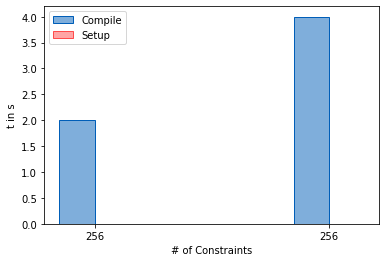

In [22]:
x = np.arange(len(constraints_opt))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, compile_opt, width, label='Compile', edgecolor='#005eb8', color='#7faedb')
rects2 = ax.bar(x + width/2, setup_opt, width, label='Setup', edgecolor='#ff4c4c', color='#ffa5a5')
ax.set_ylabel('t in s')
ax.set_xticks(x)
ax.set_xlabel('# of Constraints')
ax.set_xticklabels(constraints_opt)
ax.legend()
ax.semilogy(np.exp(0 / max(setup_opt)))
ax.set_ylim(ymin=1)
fig.tight_layout()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/compile-setup.png')
plt.show()

#### Witness and Proof Diagram:

[0, 0]


ZeroDivisionError: division by zero

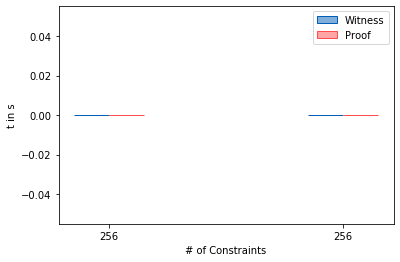

In [23]:
x = np.arange(len(constraints_opt))  # the label locations
width = 0.15  # the width of the bars
print(witness_opt)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, witness_opt, width, label='Witness', edgecolor='#005eb8', color='#7faedb')
rects2 = ax.bar(x + width/2, proof_opt, width, label='Proof', edgecolor='#ff4c4c', color='#ffa5a5')
ax.set_ylabel('t in s')
ax.set_xticks(x)
ax.set_xlabel('# of Constraints')
ax.set_xticklabels(constraints_opt)
ax.legend()
ax.semilogy(np.exp(0 / max(setup_opt)))
ax.set_ylim(ymin=0)
fig.tight_layout()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/witness-proof.png')
plt.show()